# *deJong 2016*  Composition-Based Descriptors

This notebook uses the composition descriptors from [deJong 2016](https://www.nature.com/articles/srep34256) to predict properties of compounds.

In [1]:
training_file = "datasets/oqmd_all.data"
delimiter = ' '
comp_col = "comp"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matminer

from pymatgen import Composition
from matminer.featurizers import composition as cp
from matminer.featurizers.data import MagpieData
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

## Load data
This is a dataset from OQMD, since the original deJong dataset was not provided in the paper.

In [3]:
def load_training_set(files, sep):
    """Function to read data files and load them into a Pandas DataFrame"""
        
    if type(files) is not list:
        training_set = pd.read_csv(files, sep=sep)
    else:
        training_set = pd.DataFrame()
        for i in range(len(files)):
            training_set.append(pd.read_csv(files[i], sep=sep[i]))

    return training_set

training_set = load_training_set(training_file, delimiter)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Create PyMatGen Composition objects

In [7]:
comp_objects = [Composition(comp) for comp in training_set[comp_col]]
comp_objects
training_set = training_set.assign(comp_obj=comp_objects)
training_set

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj
4,Pd1,-5.15853,15.2088,None,0.0,0.018186,0.0181856433333,True,(Pd)
7,Hf1,-9.9232,22.3676,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf)
9,In1,-2.71483,26.816,None,0.0,0.005113,0.00511323666667,True,(In)
15,Mo1,-10.4191,15.9204,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo)
16,Nb1,-9.80092,18.6733,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb)
18,Ni1,-5.55216,10.7022,0.611777266667,0.0,0.014457,0.01445706,True,(Ni)
19,Os1,-11.1811,14.2827,7.71e-05,0.0,0.044841,0.04484125,True,(Os)
21,Pb1,-3.69299,31.1795,None,0.0,0.010978,0.0109780066667,True,(Pb)
22,Pm1,-4.74148,34.2306,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm)
23,Pr1,-4.7688,35.9841,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr)


## Featurize the dataset

In [8]:
%%time

def calc_attributes(training_set):
    not_attr = list(training_set) #Non-attribute columns
    
    #Statistics and attributes to compute
    stats_list = ["std_dev"]
    for pwr in range(-4,5):
        stats_list.append("holder_mean__%d"%pwr)
    attr_list = ["AtomicWeight","Number","CovalentRadius","BoilingT","Electronegativity","Column","MeltingT","Row"]
    
    training_set_updated = cp.ElementProperty(method=None, stats=stats_list, attributes=attr_list, data_source=MagpieData()).featurize_dataframe(training_set, col_id="comp_obj")
    
    all_cols = list(training_set_updated)
    attr_names = [col for col in all_cols if col not in not_attr]
    return training_set_updated, attr_names

all_descriptors, attr_names = calc_attributes(training_set)
print np.shape(all_descriptors)

/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ne. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for He. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/jimingchen/anaconda2/lib/python2.7/site-packages/pymatgen-2017.7.4-py2.7-macosx-10.7-x86_64.egg/pymatgen/core/periodic_table.py:398: UserWarning: No electronegativity for Ar. Setting to infinity. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


(228676, 89)
CPU times: user 7min 19s, sys: 3.23 s, total: 7min 22s
Wall time: 7min 26s


In [9]:
training_set_use = all_descriptors.dropna()
training_set_use

,comp,energy_pa,volume_pa,magmom_pa,bandgap,delta_e,stability,is_groundstate,comp_obj,holder_mean__-1 AtomicWeight,...,holder_mean__4 Number,holder_mean__4 Row,std_dev AtomicWeight,std_dev BoilingT,std_dev Column,std_dev CovalentRadius,std_dev Electronegativity,std_dev MeltingT,std_dev Number,std_dev Row
4,Pd1,-5.15853,15.2088,None,0.0,0.018186,0.0181856433333,True,(Pd),106.420000,...,46.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Hf1,-9.9232,22.3676,-6.75333333333e-05,0.0,0.032166,0.032166465,True,(Hf),178.490000,...,72.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,In1,-2.71483,26.816,None,0.0,0.005113,0.00511323666667,True,(In),114.818000,...,49.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,Mo1,-10.4191,15.9204,-0.00447616666667,0.0,0.428967,0.428966556667,True,(Mo),95.960000,...,42.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,Nb1,-9.80092,18.6733,0.00419203333333,0.0,0.292991,0.292990723333,True,(Nb),92.906380,...,41.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18,Ni1,-5.55216,10.7022,0.611777266667,0.0,0.014457,0.01445706,True,(Ni),58.693400,...,28.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,Os1,-11.1811,14.2827,7.71e-05,0.0,0.044841,0.04484125,True,(Os),190.230000,...,76.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21,Pb1,-3.69299,31.1795,None,0.0,0.010978,0.0109780066667,True,(Pb),207.200000,...,82.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,Pm1,-4.74148,34.2306,0.0191255333333,0.0,0.003751,0.0037507375,True,(Pm),145.000000,...,61.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23,Pr1,-4.7688,35.9841,-0.00777663333333,0.0,0.006011,0.0060109525,True,(Pr),140.907650,...,59.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Formation Energy Prediction

In [10]:
#Energy range data
delta_e = np.array(training_set_use["delta_e"], dtype=float)

energy_range = np.zeros(np.shape(delta_e), dtype=str)
for i in range(len(delta_e)):
    if delta_e[i] < 0:
        energy_range[i] = "neg"
    else:
        energy_range[i] = "pos"
        
print energy_range

['p' 'p' 'p' ..., 'n' 'n' 'n']


In [11]:
#Classifier step
model1 = RandomForestClassifier(n_estimators=10, criterion="gini", min_samples_split=2)
model1.fit(training_set_use[attr_names], energy_range)
prediction = model1.predict(training_set_use[attr_names])

In [12]:
pd.crosstab(energy_range, prediction, rownames=["actual"], colnames=["predicted"])

predicted,n,p
actual,,
n,92241,151
p,567,135714


### Regressor Step

In [13]:
rf_model = RandomForestRegressor()
rf_model.fit(training_set_use[attr_names], delta_e)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [14]:
prediction = rf_model.predict(training_set_use[attr_names])

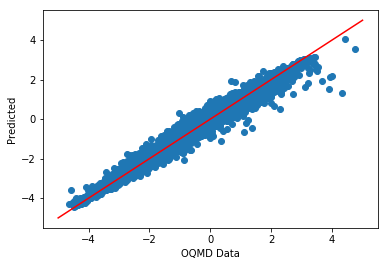

In [15]:
plt.scatter(delta_e, prediction)
plt.plot(range(-5,6), range(-5,6), 'r')
plt.xlabel("OQMD Data")
plt.ylabel("Predicted")

### Compute cross-validation error

In [16]:
%%time

errors = cross_val_score(RandomForestRegressor(), training_set_use[attr_names], delta_e, scoring="neg_mean_absolute_error", cv=10)
mae = np.mean(np.abs(errors))

print mae

0.18718155372
CPU times: user 31min 4s, sys: 6.63 s, total: 31min 11s
Wall time: 31min 18s
